# Import Libraries

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import string
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Load Datasets

In [79]:
#change the path of the files as per your system
aisles=pd.read_csv(r"C:\Users\Arpita\Downloads\instacart-market-basket-analysis\Instakart\aisles.csv")
dept=pd.read_csv(r"C:\Users\Arpita\Downloads\instacart-market-basket-analysis\Instakart\departments.csv")
order=pd.read_csv(r"C:\Users\Arpita\Downloads\instacart-market-basket-analysis\Instakart\orders.csv")
prod=pd.read_csv(r"C:\Users\Arpita\Downloads\instacart-market-basket-analysis\Instakart\products.csv")
sales_prior=pd.read_csv(r"C:\Users\Arpita\Downloads\instacart-market-basket-analysis\Instakart\order_products__prior.csv")
ord_train=pd.read_csv(r"C:\Users\Arpita\Downloads\instacart-market-basket-analysis\Instakart\order_products__train.csv")

In [80]:
order.columns  #1,2,3,4, --> order_id

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [81]:
sales_prior.columns   # 3,4,5  --> order_id

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

left join --> order and sales_prior --> order_id --> 
combined --> order_id (1,2,3,4) -->  order_id --> 1 was not present in 2nd csv --> NaN for reordered, 'product_id', 'add_to_cart_order'

# EDA

In [3]:
print(order.isnull().sum())

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


In [4]:
daymed=(order['days_since_prior_order'].median())
print('Mean of days sice last order = ', daymed)
print('\n\n')
order['days_since_prior_order']=order['days_since_prior_order'].fillna(daymed)
print(order.isnull().sum())

Mean of days sice last order =  7.0



order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64


## Feature Engineering Users

In [5]:
# Creating a dataset with only the prior orders

# This ensures only the entries that are common to both the tables are included, and similar 
# order ids can be counted multiple times if they have different product ids

op = pd.merge(order, sales_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,7.0,196,1,0
1,2539329,1,prior,1,2,8,7.0,14084,2,0
2,2539329,1,prior,1,2,8,7.0,12427,3,0
3,2539329,1,prior,1,2,8,7.0,26088,4,0
4,2539329,1,prior,1,2,8,7.0,26405,5,0


In [6]:
# We calculate the total number of orders each user has placed

users = op.groupby(by='user_id')['order_number'].aggregate('max').to_frame('u_num_of_orders').reset_index()
users.head()

,user_id,u_num_of_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [7]:
# Now we get the average number of products each user buys including all their orders

#1. First we get the total number of products per user per order

total_prd_per_order = op.groupby(by=['user_id', 'order_id'])['product_id'].aggregate('count').to_frame('total_products_per_order').reset_index()
total_prd_per_order.head(10)

,user_id,order_id,total_products_per_order
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6
5,1,2398795,6
6,1,2539329,5
7,1,2550362,9
8,1,3108588,6
9,1,3367565,4


In [8]:
#2. Now we get the average number of products purchased by each user overall

avg_products = total_prd_per_order.groupby(by=['user_id'])['total_products_per_order'].mean().to_frame('u_avg_prd').reset_index()
avg_products.head()

,user_id,u_avg_prd
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


In [9]:
# Deleting the total products column which is no longer needed

del total_prd_per_order

In [10]:
# Calculating which day of the week does each user place most orders

dow = op.groupby(by='user_id')['order_dow'].agg(lambda x: stats.mode(x)[0]).to_frame('dow_most_orders_u').reset_index()
dow.head()


#user1: 1,1,1,0,7,7,7,1,1 --> 1 , count : 9, max : 7
#user2: 2,2,6,6,6,6,6,6,0 --> 6

,user_id,dow_most_orders_u
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3


In [11]:
# Calculating which hour of the day does each user place most orders

hod = op.groupby(by='user_id')['order_hour_of_day'].agg(lambda x: (stats.mode(x)[0])).to_frame('hod_most_orders_u').reset_index()
hod.head()


,user_id,hod_most_orders_u
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18


In [12]:
# Now we merge all the features that we just extracted from our datset, one by one

#1. Merging avg products per users with users ids

users = users.merge(avg_products, on='user_id', how='left')
del avg_products
users.head()

,user_id,u_num_of_orders,u_avg_prd
0,1,10,5.900000
1,2,14,13.928571
2,3,12,7.333333
3,4,5,3.600000
4,5,4,9.250000


In [13]:
#2. Merging day of maximum purchase with database obtained in last step

users = users.merge(dow, on='user_id', how='left')
#deleting dow
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u
0,1,10,5.900000,4
1,2,14,13.928571,2
2,3,12,7.333333,0
3,4,5,3.600000,4
4,5,4,9.250000,3


In [14]:
#3. Merging hour of maximum purchase with database produced in last step

users = users.merge(hod, on='user_id', how='left')
del hod
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u
0,1,10,5.900000,4,7
1,2,14,13.928571,2,9
2,3,12,7.333333,0,16
3,4,5,3.600000,4,15
4,5,4,9.250000,3,18


## Feature Engineering Products

In [15]:
# Number of times a particluar product was purchased

prd = op.groupby(by='product_id')['order_id'].agg('count').to_frame('prd_count_p').reset_index()
prd.head()

,product_id,prd_count_p
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [16]:
# Reorder ratio for each product

reorder_p = op.groupby(by='product_id')['reordered'].agg('mean').to_frame('p_reordered_ratio').reset_index()
reorder_p.head()

,product_id,p_reordered_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


In [17]:
# Merging the reorder ratio with product ids

prd = prd.merge(reorder_p, on='product_id', how='left')

#deleting reorder_p

del reorder_p
prd.head()

,product_id,prd_count_p,p_reordered_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


## Creating user product features

In [18]:
# How many times has a user bought a particular product

uxp = op.groupby(by=['user_id', 'product_id'])['order_id'].agg('count').to_frame('uxp_times_bought').reset_index()
uxp.head()

,user_id,product_id,uxp_times_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [19]:
# Reorder ratio of each user for each product

reorder_uxp = op.groupby(by=['user_id', 'product_id'])['reordered'].agg('mean').to_frame('uxp_reordered_ratio').reset_index()
reorder_uxp.head()

,user_id,product_id,uxp_reordered_ratio
0,1,196,0.900000
1,1,10258,0.888889
2,1,10326,0.000000
3,1,12427,0.900000
4,1,13032,0.666667


In [20]:
# Merging the user-product and product-reorder dataframes into one

uxp = uxp.merge(reorder_uxp, on=['user_id', 'product_id'], how='left')

del reorder_uxp
uxp.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio
0,1,196,10,0.900000
1,1,10258,9,0.888889
2,1,10326,1,0.000000
3,1,12427,10,0.900000
4,1,13032,3,0.666667


## Merging Final

In [21]:
# Merging users dataframe into the dataframe we obtianed in our last step

data = uxp.merge(users, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u
0,1,196,10,0.900000,10,5.9,4,7
1,1,10258,9,0.888889,10,5.9,4,7
2,1,10326,1,0.000000,10,5.9,4,7
3,1,12427,10,0.900000,10,5.9,4,7
4,1,13032,3,0.666667,10,5.9,4,7


In [22]:
# Merging products dataframe into the existing dataframe

data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158


In [23]:
# Deleting columns that are no longer significant

del [users, prd, uxp]

In [24]:
data.shape

(13307953, 10)

In [25]:
data.columns

Index(['user_id', 'product_id', 'uxp_times_bought', 'uxp_reordered_ratio',
       'u_num_of_orders', 'u_avg_prd', 'dow_most_orders_u',
       'hod_most_orders_u', 'prd_count_p', 'p_reordered_ratio'],
      dtype='object')

In [26]:
# Fitering out the train and test eval set from the orders dataframe

order_future = order.loc[((order.eval_set == 'train') | (order.eval_set == 'test')), ['user_id', 'eval_set', 'order_id']]
order_future.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [27]:
# Merging train and test eval set from previous step with the info we have about users and products

data = data.merge(order_future, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899


In [28]:
# Filtering out the train dataframe

data_train = data[data.eval_set == 'train']
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899


In [29]:
# Merging the information from the order_proucts_train dataframe into the data_train dataframe

data_train = data_train.merge(ord_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899,NaN
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899,NaN
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899,1.0


In [30]:
# Filling out the "not avaialble" cells

data_train.reordered.fillna(0, inplace=True)

In [31]:
# Setting user_id and product_id as index

data_train = data_train.set_index(['user_id', 'product_id'])

# Deleting eval_set, order_id as they are not significant to training.

data_train.drop(['eval_set', 'order_id'], axis=1, inplace=True)

In [32]:
data_train.head()

uxp_times_bought  uxp_reordered_ratio  u_num_of_orders  \
user_id product_id                                                           
1       196                       10             0.900000               10   
        10258                      9             0.888889               10   
        10326                      1             0.000000               10   
        12427                     10             0.900000               10   
        13032                      3             0.666667               10   

                    u_avg_prd  dow_most_orders_u  hod_most_orders_u  \
user_id product_id                                                    
1       196               5.9                  4                  7   
        10258             5.9                  4                  7   
        10326             5.9                  4                  7   
        12427             5.9                  4                  7   
        13032             5.9                  4                  7   

                    prd_count_p  p_reordered_ratio  reordered  
user_id product_id                                             
1       196               35791           0.776480        1.0  
        10258              1946           0.713772        1.0  
        10326              5526           0.652009        0.0  
        12427              6476           0.740735        0.0  
        13032              3751           0.657158        1.0

In [33]:
# Filtering out the test dataframe

data_test = data[data.eval_set == 'test']
data_test.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
120,3,248,1,0.000000,12,7.333333,0,16,6371,0.400251,test,2774568
121,3,1005,1,0.000000,12,7.333333,0,16,463,0.440605,test,2774568
122,3,1819,3,0.666667,12,7.333333,0,16,2424,0.492162,test,2774568
123,3,7503,1,0.000000,12,7.333333,0,16,12474,0.553551,test,2774568
124,3,8021,1,0.000000,12,7.333333,0,16,27864,0.591157,test,2774568


In [34]:
# Deleting eval_set, order_id as they are not significant to test dataframe

data_test.drop(['eval_set', 'order_id'], axis=1, inplace=True)

In [35]:
# Setting user_id and product_id as index

data_test = data_test.set_index(['user_id', 'product_id'])

In [36]:
data_test.head()

uxp_times_bought  uxp_reordered_ratio  u_num_of_orders  \
user_id product_id                                                           
3       248                        1             0.000000               12   
        1005                       1             0.000000               12   
        1819                       3             0.666667               12   
        7503                       1             0.000000               12   
        8021                       1             0.000000               12   

                    u_avg_prd  dow_most_orders_u  hod_most_orders_u  \
user_id product_id                                                    
3       248          7.333333                  0                 16   
        1005         7.333333                  0                 16   
        1819         7.333333                  0                 16   
        7503         7.333333                  0                 16   
        8021         7.333333                  0                 16   

                    prd_count_p  p_reordered_ratio  
user_id product_id                                  
3       248                6371           0.400251  
        1005                463           0.440605  
        1819               2424           0.492162  
        7503              12474           0.553551  
        8021              27864           0.591157

In [37]:
# Resetting index

data_train.reset_index(inplace=True)
data_test.reset_index(inplace=True)

In [38]:
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,0.0
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,0.0
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,1.0


In [39]:
# Merging the aisles and department ids with the train and test data

#aisle
data_train = data_train.merge(prod[['product_id', 'aisle_id']], on='product_id', how='left')
data_test = data_test.merge(prod[['product_id', 'aisle_id']], on='product_id', how='left')

In [40]:
#department
data_train = data_train.merge(prod[['product_id', 'department_id']], on='product_id', how='left')
data_test = data_test.merge(prod[['product_id', 'department_id']], on='product_id', how='left')

In [41]:
#setting user_id and product_id as index for test set

data_test = data_test.set_index(['user_id', 'product_id'])

#setting user_id and product_id as index for train set

data_train = data_train.set_index(['user_id', 'product_id'])

In [42]:
print(data_test.shape)
print(data_train.shape)

(4833292, 10)
(8474661, 11)


[20:48:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_boost_round, parameters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:48:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


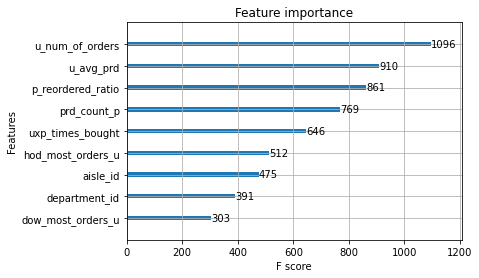

In [43]:
#Building a XGBoost model.

#importing the package.
import xgboost as xgb

#splitting the train data into training and testing set.
X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

#setting boosters parameters
parameters = {
    'eavl_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

#instantiating the model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

# TRAIN MODEL
model = xgb_clf.fit(X_train, y_train)

#FEATURE IMPORTANCE - GRAPHICAL
xgb.plot_importance(model)

In [44]:
#predicting on the testing data
y_pred = xgb_clf.predict(data_test).astype('int')

#setting a threshold.
y_pred = (xgb_clf.predict_proba(data_test)[:, 1] >= 0.21).astype('int')
y_pred[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [45]:
#saving the prediction as a new column in data_test
data_test['prediction'] = y_pred
data_test.head()

uxp_times_bought  uxp_reordered_ratio  u_num_of_orders  \
user_id product_id                                                           
3       248                        1             0.000000               12   
        1005                       1             0.000000               12   
        1819                       3             0.666667               12   
        7503                       1             0.000000               12   
        8021                       1             0.000000               12   

                    u_avg_prd  dow_most_orders_u  hod_most_orders_u  \
user_id product_id                                                    
3       248          7.333333                  0                 16   
        1005         7.333333                  0                 16   
        1819         7.333333                  0                 16   
        7503         7.333333                  0                 16   
        8021         7.333333                  0                 16   

                    prd_count_p  p_reordered_ratio  aisle_id  department_id  \
user_id product_id                                                            
3       248                6371           0.400251       117             19   
        1005                463           0.440605        94              7   
        1819               2424           0.492162        88             13   
        7503              12474           0.553551       117             19   
        8021              27864           0.591157        54             17   

                    prediction  
user_id product_id              
3       248                  0  
        1005                 0  
        1819                 0  
        7503                 0  
        8021                 0

In [46]:
data_test.shape

(4833292, 11)

In [48]:
data_test.columns

Index(['uxp_times_bought', 'uxp_reordered_ratio', 'u_num_of_orders',
       'u_avg_prd', 'dow_most_orders_u', 'hod_most_orders_u', 'prd_count_p',
       'p_reordered_ratio', 'aisle_id', 'department_id', 'prediction'],
      dtype='object')

In [50]:
data_test['prediction'].value_counts()

0    4266616
1     566676
Name: prediction, dtype: int64

In [66]:
print(data_test.columns)
# Reset the index
final = data_test.reset_index()
print(final.columns)
# Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]

#gc.collect()
final.head()

Index(['uxp_times_bought', 'uxp_reordered_ratio', 'u_num_of_orders',
       'u_avg_prd', 'dow_most_orders_u', 'hod_most_orders_u', 'prd_count_p',
       'p_reordered_ratio', 'aisle_id', 'department_id', 'prediction'],
      dtype='object')
Index(['user_id', 'product_id', 'uxp_times_bought', 'uxp_reordered_ratio',
       'u_num_of_orders', 'u_avg_prd', 'dow_most_orders_u',
       'hod_most_orders_u', 'prd_count_p', 'p_reordered_ratio', 'aisle_id',
       'department_id', 'prediction'],
      dtype='object')


,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [67]:
#orders = pd.read_csv(PATH + 'orders_final.csv')
orders_test = order.loc[order.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [68]:
orders_test['user_id'].isna().sum()

0

In [69]:
#merging our prediction with orders_test
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [70]:
#remove user_id column
final = final.drop('user_id', axis=1)

In [74]:
#convert product_id as integer
import gc
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
#del orders
#del orders_test
gc.collect()

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [75]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

#We now check how the dictionary were populated (open hidden output)
d

{2774568: '9387 17668 21903 39190 43961 47766',
 1528013: '21903 38293',
 1376945: '8309 8670 14947 27959 28465 33572 34658 35640 35948 42585 44632',
 1356845: '7076 10863 13176 14992 21616 28134',
 2161313: '196 10441 11266 12427 14715 27839 37710',
 1416320: '5134 17948 21137 21903 24852 28985 41950',
 1735923: '196 2192 12108 13249 14252 15131 17008 18174 24629 31487 34690 35123',
 1980631: '6184 9387 13575 13914 22362 41400 46061',
 139655: '13176 22935 27845',
 1411408: '22008 43758',
 2940603: '7521 14947 19894 30592 31615 44632',
 1192143: '24759 24852 47626',
 280888: '12440 19213 41406',
 3202221: '2452 4793 6069 7781 9203 9637 11130 13629 17630 21137 21927 24852 39911 45364 46979 49215',
 3222866: '7039 7969 8501 14947 15718 18894 32441 32912 33198 34254 35921 37131 38690',
 707453: '694 4942 18150 21137 21267 21903 24852 26209 28156 32030 37766 39275 42585 44142 44830 45066 46802 47766 48230',
 1320132: '11079 44632',
 882556: '1870 5373 5450 7371 8424 9076 12857 17794 21903

In [76]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,9387 17668 21903 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 8670 14947 27959 28465 33572 34658 35640 ...
3,1356845,7076 10863 13176 14992 21616 28134
4,2161313,196 10441 11266 12427 14715 27839 37710


In [77]:
sub.to_csv('sub.csv', index=False)